In [1]:
import json
from pathlib import *

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline, splev, splrep
from scipy.optimize import curve_fit
from sympy import *
from gen_latinv import *
from ase.data import atomic_numbers, atomic_names, atomic_masses, covalent_radii
import pandas as pd

In [2]:
He_atom = 0.00168913
Ta_atom = -2.24248703

params = {}

def combinfunc(f1, df1, potp, rin, z1, z2):
    c = f1(rin, *potp) - zblSec(rin, z1, z2)
    def func(r):
        result = np.where(r < rin, zblSec(r, z1, z2)+c, f1(r, *potp))
        return result
    def dfunc(r):
        result = np.where(r < rin, dzblSec(r, z1, z2), df1(r, *potp))
        return result
    return func, dfunc

def combinfunc_(f1, df1, rin, z1, z2):
    c = f1(rin) - zblSec(rin, z1, z2)
    def func(r):
        result = np.where(r < rin, zblSec(r, z1, z2)+c, f1(r))
        return result
    def dfunc(r):
        result = np.where(r < rin, dzblSec(r, z1, z2), df1(r))
        return result
    return func, dfunc

## 2.计算Ta-Ta的LIP
### 2.1 对结合能曲线进行插值

In [3]:
amin = 2.0
amax = 7.4
rc = 8.0
D = 0.01
def weight(x):
    # x > 0 w=0.2
    # x < 0 x靠近-10,w越大 , w最大值1.5
    w = np.where(x < 0, 1.1, 0.5)
    return w
def cutoff(r, f, rc, D):
    result = np.zeros_like(r)
    # r<rc-D 时，result=1
    result[r < rc - D] = 1
    # rc-D<r< rc+D 时，result=1/2+1/2*cos(pi*(r-rc)/D)
    result[(r >= rc - D) & (r <= rc + D)] = 0.5 - 0.5 * np.sin(0.5*np.pi * (r[(r >= rc - D) & (r <= rc + D)] - rc) / D)
    result = result * f(r)
    return result

# potp是势能函数的参数，r是距离，rc是截断半径，D是平滑区间, f是势能函数
def cutoff_(r, f, rc, D, potp):
    result = np.zeros_like(r)
    # r<rc-D 时，result=1
    result[r < rc - D] = 1
    # rc-D<r< rc+D 时，result=1/2+1/2*cos(pi*(r-rc)/D)
    result[(r >= rc - D) & (r <= rc + D)] = 0.5 - 0.5 * np.sin(0.5*np.pi * (r[(r >= rc - D) & (r <= rc + D)] - rc) / D)
    result = result * f(r, *potp)
    return result

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1
 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1
 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1
 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1
 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1]


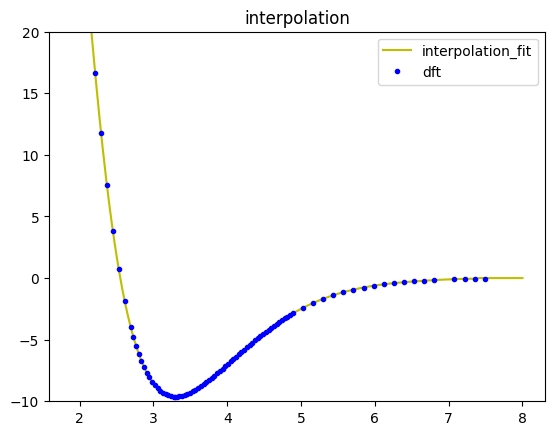

In [4]:
bcc_data = pd.read_csv("./lattice_inv_data/Ta_bcc.csv")
bcc_x = bcc_data["alat"].values
bcc_e = (bcc_data['energy'].values - 2 * Ta_atom) / 2
w = weight(bcc_e)
bcc = UnivariateSpline(bcc_x, bcc_e, s=0.005,w=w, k=3)
plat = np.linspace(amin, rc, num=500)
ep = cutoff(plat, bcc, amax, D)
plt.plot(plat, ep, 'y-',label=f'interpolation_fit')
plt.plot(bcc_x, bcc_e, 'b.',label='dft')
plt.legend()
plt.ylim([-10,20])
plt.title("interpolation")
plt.show()

### 2.2对Ta进行反演

In [5]:
def morse_Ta(r, D , a, r0, C, n,m1,l1,r1):
    return D*(np.exp(-2*a*(r-r0)-2*np.exp(-a*(r-r0)))) + C/np.power(r,n) + m1*np.exp(-l1*(r-r1)**2)

def de_morse_Ta(r, D , a, r0, C, n,m1,l1,r1):
    return -C*n/(r*r**n) + D*(-2*a + 2*a*np.exp(-a*(r - r0)))*np.exp(-2*a*(r - r0) - 2*np.exp(-a*(r - r0))) - l1*m1*(2*r - 2*r1)*np.exp(-l1*(r - r1)**2)

def weight(r):
    w = np.exp(-0.0001*(r-4.7)**16)
    return w

c:\Users\wff19\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(0.0, 0.02)

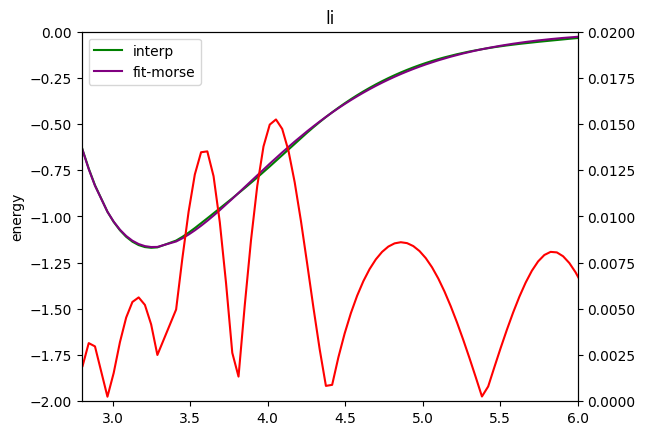

In [6]:
NITEM = 20
nr = 150
rs = amin
rc = rc
rArr = np.linspace(rs,rc,nr)
aArr = rArr * 2 / np.sqrt(3)
bnArr, InArr,_ = generate_latinvpara("BCC",NITEM)
bnArr = np.array(bnArr).reshape(-1,1)
InArr = np.array(InArr).reshape(-1,1)
en =  np.sum(InArr * cutoff(bnArr*aArr, bcc, amax, D), axis=0)*2
# 删除3.32-3.4之间的点
index = np.where((rArr > 3.32) & (rArr < 3.4))
rArr = np.delete(rArr, index)
en = np.delete(en, index)
# 删除2.89-2.95之间的点
index = np.where((rArr > 2.89) & (rArr < 2.95))
rArr = np.delete(rArr, index)
en = np.delete(en, index)
f3 = UnivariateSpline(rArr, en, s=0.002, k=3)
popt_Ta, pcov = curve_fit(morse_Ta, rArr[20:-20], en[20:-20], p0=[-15, 1, 3,400, 5,1,1,1], maxfev=500000)
# %matplotlib tk
fig, a1 = plt.subplots()
#添加子图区域
# a1.plot(rArr, en, 'y-',label=f'inver')
a1.plot(rArr, f3(rArr), 'g-',label=f'interp')
a1.plot(rArr, morse_Ta(rArr, *popt_Ta), 'purple',label=f'fit-morse')
a1.set_ylabel('energy')
plt.legend()
plt.title("li")
err = np.abs(f3(rArr) - morse_Ta(rArr, *popt_Ta))
# 右轴
a2 = a1.twinx()
plt.plot(rArr, err, 'r-',label=f'err')
plt.xlim(2.8, 6)
# 左轴-2,0， 右轴0，0.02
a1.set_ylim(-2, 0)
a2.set_ylim(0, 0.02)

In [19]:
### 输出csv
rc = 6.8
rc2 = 6.9
D = 0.01
rArr = np.concatenate((np.linspace(0.01, 2, 20, endpoint=False),np.linspace(2, 7.0, 200)), axis=0)
rin = 2.2
rArr = np.sort(np.append(rArr, rin))
Ta_func = combinfunc(morse_Ta, de_morse_Ta, popt_Ta, rin, atomic_numbers['Ta'], atomic_numbers['Ta'])

data = np.vstack((rArr, cutoff(rArr, Ta_func[0], rc, D),-cutoff(rArr, Ta_func[1], rc2, D))).T
with open("./out/Ta.csv",'w') as f:
    f.write("r,E,F\n")
    for i in data:
        f.write(f"{i[0]},{i[1]},{i[2]}\n")

## 3.计算He的LIP
### 3.1 对He的结合能曲线进行插值

In [36]:
He_amin = 1
He_amax = 4
He_rc = 3.5

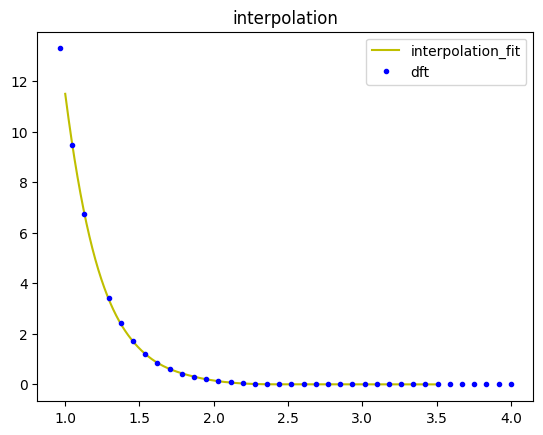

In [37]:
He_data = pd.read_csv("./lattice_inv_data/He_sc.csv", header=0)
He_x = He_data['lat'].values
He_e = He_data['energy'].values - He_atom
He_interp = UnivariateSpline(He_x, He_e, s=0.01, k=3)
He_plat = np.linspace(He_amin, He_rc, num=1000)
He_ep = cutoff(He_plat, He_interp, He_amax, D)
plt.plot(He_plat, He_ep, 'y-',label=f'interpolation_fit')
plt.plot(He_x, He_e, 'b.',label='dft')
plt.legend()
plt.title("interpolation")
plt.show()

In [38]:
# 定义需要拟合的函数
def Morse_He(r, D , a, r0, C, n, E, b, m, l):
    return D*(np.exp(-2*a*(r-r0)-2*np.exp(-a*(r-r0)))) + C/np.power(r,n) + E*np.exp(-b*r**2-m*r-l)
def de_Morse_He(r, D , a, r0, C, n, E, b, m, l):
    return -C*n/(r*r**n) + D*(-2*a + 2*a*np.exp(-a*(r - r0)))*np.exp(-2*a*(r - r0) - 2*np.exp(-a*(r - r0))) + E*(-2*b*r - m)*np.exp(-b*r**2 - l - m*r)

[ 0.85667057  4.93208108  1.36692616 -1.50022689  7.95755125  2.24714073
  1.24933416 -1.35761809  0.01850096]


C:\Users\wff19\AppData\Local\Temp\ipykernel_28488\4200720098.py:3: RuntimeWarning: overflow encountered in exp
  return D*(np.exp(-2*a*(r-r0)-2*np.exp(-a*(r-r0)))) + C/np.power(r,n) + E*np.exp(-b*r**2-m*r-l)


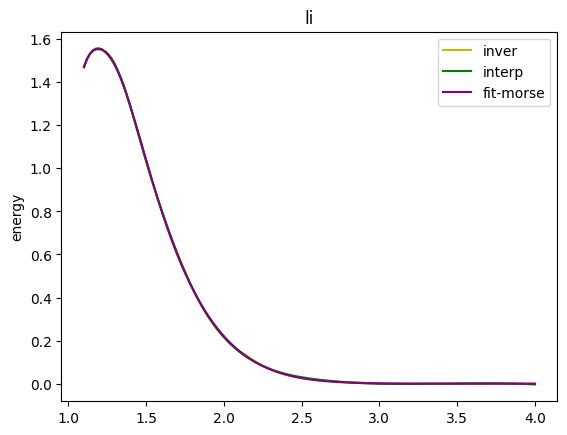

In [40]:
NITEM = 30
nr = 150
rs = 1.1
rc = 4
rArr = np.linspace(rs,rc,nr)
aArr = rArr
bnArr, InArr,_ = generate_latinvpara("SC", NITEM)
bnArr = np.array(bnArr).reshape(-1,1)
InArr = np.array(InArr).reshape(-1,1)
en =  np.sum(InArr * cutoff(bnArr*aArr, He_bcc, 3.0, D), axis=0)*2
f3 = UnivariateSpline(rArr, en, s=0.001, k=3)
popt_He, pcov = curve_fit(Morse_He, rArr[:-20], en[:-20], maxfev=1000000)
print(popt_He)
%matplotlib inline
fig, a1 = plt.subplots()
#添加子图区域
a1.plot(rArr, en, 'y-',label=f'inver')
a1.plot(rArr, f3(rArr), 'g-',label=f'interp')
a1.plot(rArr, cutoff_(rArr, Morse_He, rc, D, popt_He), 'purple',label=f'fit-morse')
a1.set_ylabel('energy')
plt.legend()
plt.title("li")
plt.show()
err = np.abs(f3(rArr) - cutoff_(rArr, Morse_He, rc, D, popt_He))

In [42]:
### 输出csv
rc = 2.5
rc2 = 2.5
D = 0.01
rArr = np.concatenate((np.linspace(0.01, 1.4, 20, endpoint=False),np.linspace(1.4, 3.0, 100)), axis=0)
rin = 1.4
rArr = np.sort(np.append(rArr, rin))
He_func = combinfunc(Morse_He, de_Morse_He, popt_He, rin, atomic_numbers['He'], atomic_numbers['He'])

data = np.vstack((rArr, cutoff(rArr, He_func[0], rc, D),-cutoff(rArr, He_func[1], rc2, D))).T
# data = np.vstack((rArr,  cutoff_(rArr, Morse_He, rc, D, popt_He), -cutoff_(rArr, de_Morse_He, rc2, D, popt_He))).T
with open("./out/He.csv",'w') as f:
    f.write("r,E,F\n")
    for i in data:
        f.write(f"{i[0]},{i[1]},{i[2]}\n")
        
params["He"] = {
    "r": list(data[:,0]),
    "E": list(data[:,1]),
    "F": list(data[:,2]),
    "E_rc": rc,
    "F_rc": rc2,
}

In [13]:
# params输出为json文件
json.dump(params, open("./out/params.json", 'w'))